In [1]:
!pip install scikit-learn
!pip install sklearn_time
!pip install snapml
!pip install matplotlib
!pip install pandas 
!pip install numpy 
%matplotlib inline

ERROR: Could not find a version that satisfies the requirement snapml (from versions: none)
ERROR: No matching distribution found for snapml


In [9]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score

In [10]:
# download the dataset
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

# read the input data
raw_data=pd.read_csv(url)
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


In [11]:
# display the first rows in the dataset
raw_data.head

<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.

In [14]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


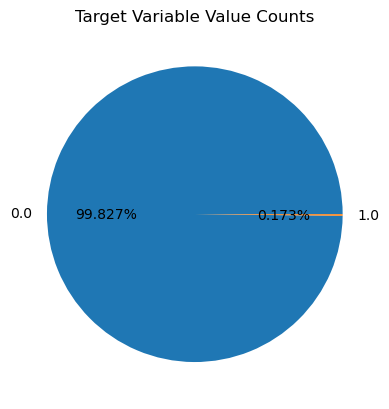

In [16]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

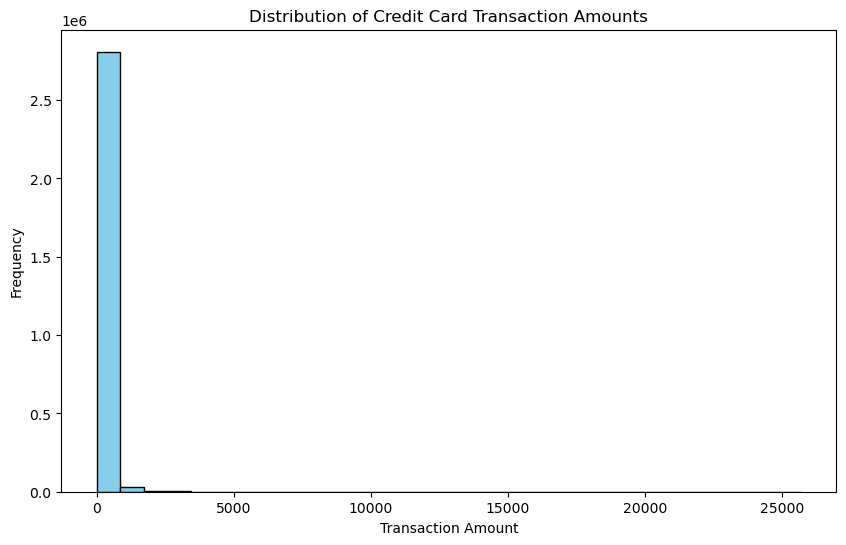

Minimum Amount: 0.0
Maximum Amount: 25691.16
90th Percentile: 203.0


In [22]:
# Ensure big_raw_data is a single column of transaction amounts
# If big_raw_data is a DataFrame, select the column like this:
transaction_amounts = big_raw_data['Amount']  # Adjust 'Amount' to the correct column name

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(transaction_amounts, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Card Transaction Amounts')
plt.show()

# Calculate min, max, and 90th percentile
min_amount = transaction_amounts.min()
max_amount = transaction_amounts.max()
percentile_90 = transaction_amounts.quantile(0.90)

print("Minimum Amount:", min_amount)
print("Maximum Amount:", max_amount)
print("90th Percentile:", percentile_90)


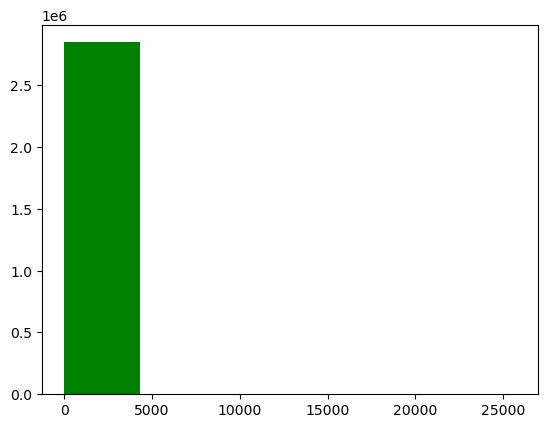

Minimum amount value is  0.0
Maximum amount value is  25691.16
90% of the transactions have an amount less or equal than  203.0


In [24]:
# we provide our solution here
plt.hist(big_raw_data.Amount.values, 6, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

In [26]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


In [30]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  31.11872


In [31]:
# if not already computed, 
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
# w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from Snap ML
from snapml import DecisionTreeClassifier

# Snap ML offers multi-threaded CPU/GPU training of decision trees, unlike scikit-learn
# to use the GPU, set the use_gpu parameter to True
# snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

ModuleNotFoundError: No module named 'snapml'

In [33]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference and compute the probabilities of the test samples 
# to belong to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

NameError: name 'snapml_time' is not defined

In [35]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

D:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[Scikit-Learn] Training time (s):  74.95


D:\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [37]:
from sklearn.svm import SVC
from snapml import SupportVectorMachine
from sklearn.metrics import hinge_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification

# Generate synthetic data for example purposes
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
# Encode labels if necessary
y = LabelEncoder().fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Scikit-Learn SVM model
sklearn_svm = SVC(kernel='linear')
sklearn_svm.fit(X_train, y_train)
sklearn_predictions = sklearn_svm.decision_function(X_test)

# Train a Snap ML SVM model
snapml_svm = SupportVectorMachine(max_iter=100)
snapml_svm.fit(X_train, y_train)
snapml_predictions = snapml_svm.decision_function(X_test)

# Compute hinge loss for both models
sklearn_hinge_loss = hinge_loss(y_test, sklearn_predictions)
snapml_hinge_loss = hinge_loss(y_test, snapml_predictions)

# Print the hinge losses
print("Hinge Loss (Scikit-Learn):", sklearn_hinge_loss)
print("Hinge Loss (Snap ML):", snapml_hinge_loss)


ModuleNotFoundError: No module named 'snapml'

In [39]:
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred  = snapml_svm.decision_function(X_test)

# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

# evaluate the hinge loss from the predictions
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss:   {0:.3f}".format(loss_snapml))

# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_snapml))

# the two models should give the same Hinge loss

NameError: name 'snapml_svm' is not defined